## Objectif du TD N°1 interpretable Machine Learning


Ce td vise à interpréter les modèles de machine learning que vous avez crées lors du TD N°2 SVM.

Vous chercherez à interpréter globalement votre modèle avec les méthodes vues en cours et surtout examiner la différence entre des modèles linéaires et non linéaires.


## Enoncé du TD

### Importer le modèle du TD N°2

1. Importer le jeu de données breast cancer disponible dans le module sklearn.datasets
2. Importer un modèle non linéaire utilisé lors du TD N°2 ou alors recréer l'ensemble de la pipeline visant à le générer
3. Vérifier que votre modèle réalise correctement une prédiction pour un individu


### Comparer interprétation des coéfficients et méthode globale

4. Lancer un modèle de régression logistique sur le jeu de données data breast cancer et interpréter les résultats
5. Utiliser maintenant les différentes méthodes d'interprétation de modèle avec les résultats de le résultats des coefficients de la reg logistique
   1. Partial depence plot
   2. Accumulated Local Effect
   3. H-Statistic
   4. Feature permutation 
6. Commenter

### Interpréter un modèle non linéaire

7. Interpréter votre modèle non linéaire (SVM avec noyau) avec l'aide des méthodes globales
8. Commenter la différence de résultat






## Partie Code

#### 1)Importer le jeu de données breast cancer disponible dans le module sklearn.datasets

In [1]:
#!pip install -r "C:/Users/Jasmine/Documents/Nantes/cours/M2/SVM_python/roul/cours_iae/04_INTERPRETABLE_ML/td/requirements_interpretability.txt"

ERROR: Could not install packages due to an OSError: [WinError 5] Accès refusé: 'C:\\Users\\Jasmine\\anaconda3\\Lib\\site-packages\\pywin32_system32\\pythoncom311.dll'
Consider using the `--user` option or check the permissions.




  Obtaining dependency information for alibi==0.9.6 from https://files.pythonhosted.org/packages/bc/00/bc8caafbabf675a15f08e8cd6d86eedb5949e2cec5ec73157d71f62abd79/alibi-0.9.6-py3-none-any.whl.metadata
  Obtaining dependency information for artemis==0.0.0 from https://files.pythonhosted.org/packages/fb/79/7f7bf4d6c4ce3297842e2ea1fd6cb7b1f771bdf05c1a69523084491809f5/artemis-0.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for asttokens==3.0.0 from https://files.pythonhosted.org/packages/25/8a/c46dcc25341b5bce5472c718902eb3d38600a903b14fa6aeecef3f21a46f/asttokens-3.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for attrs==23.2.0 from https://files.pythonhosted.org/packages/e0/44/827b2a91a5816512fcaf3cc4ebc465ccd5d598c45cefa6703fcf4a79018f/attrs-23.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for blis==0.7.11 from https://files.pythonhosted.org/packages/2f/09/da0592c74560cc33396504698122f7a56747c82a5e072ca7d2c3397898e1/blis-0.7.11-c

In [13]:
!pip install artemis

  Obtaining dependency information for artemis from https://files.pythonhosted.org/packages/fb/79/7f7bf4d6c4ce3297842e2ea1fd6cb7b1f771bdf05c1a69523084491809f5/artemis-0.0.0-py3-none-any.whl.metadata
  Using cached artemis-0.0.0-py3-none-any.whl.metadata (115 bytes)
Using cached artemis-0.0.0-py3-none-any.whl (1.2 kB)


In [78]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.stats.mstats import winsorize

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier , LogisticRegression

#Interpretability
from sklearn.inspection import partial_dependence, PartialDependenceDisplay, permutation_importance
from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod
from alibi.explainers import ALE, plot_ale

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'artemis.interactions_methods'

In [42]:
def winsorize_data(xtrain, xtest, feature):

    """_summary_

    Fonction permettant de winsorizez un jeu d'entrainement et de test en calculant
    les quantiles sur le jeu d'entrainement et l'appliquant sur le jeu test.

    Pour se prémunir d'un data leak.
    
    """
    
    # Définir les quantiles sur xtrain
    lower_quantile = 0.05  # 5% quantile
    upper_quantile = 0.95  # 95% quantile

    # Calcul des bornes à partir des quantiles sur xtrain
    lower_bound = np.quantile(xtrain[feature], lower_quantile)
    upper_bound = np.quantile(xtrain[feature], upper_quantile)

    # Appliquer la winsorisation sur xtrain
    xtrain_winsorized = np.clip(xtrain[feature], lower_bound, upper_bound)

    # Appliquer les mêmes bornes sur xtest
    xtest_winsorized = np.clip(xtest[feature], lower_bound, upper_bound)

    return(xtrain_winsorized, xtest_winsorized)

In [16]:
#Load dataset breast cancer
data = load_breast_cancer()

breast = pd.DataFrame(data = np.c_[data.data,data.target], columns=list(data.feature_names)+['target'] )

#Nom des colonnes et remplacer les espaces par un "_"
features_name = [name.replace(" ", "_") for name in data.feature_names]
breast.columns= features_name+['target']

In [17]:
breast

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0.0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0.0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0.0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0.0


#### 2) Recréer l'ensemble de la pipeline visant à le générer votre meilleur modèle du td 02_SVM_kernel


In [77]:
m_corr = breast[features_name].corr(method="spearman")
fig = plt.figure(figsize=(36,36), dpi = 480)
sns.heatmap(m_corr[abs(m_corr)>=0.80],annot = True, fmt = '.2f')

<Axes: >

In [21]:
#On ne garde que la partie supérieur de la matrice de corrélation car symétrique
#On inclut pas la diagonale car variable corrlée à 100% avec elle même
upper_tri = m_corr.where(np.triu(np.ones(m_corr.shape), k=1).astype(bool))
print(upper_tri)

                         mean_radius  mean_texture  mean_perimeter  mean_area  \
mean_radius                      NaN      0.340956        0.997802   0.999602   
mean_texture                     NaN           NaN        0.348142   0.344145   
mean_perimeter                   NaN           NaN             NaN   0.997068   
mean_area                        NaN           NaN             NaN        NaN   
mean_smoothness                  NaN           NaN             NaN        NaN   
mean_compactness                 NaN           NaN             NaN        NaN   
mean_concavity                   NaN           NaN             NaN        NaN   
mean_concave_points              NaN           NaN             NaN        NaN   
mean_symmetry                    NaN           NaN             NaN        NaN   
mean_fractal_dimension           NaN           NaN             NaN        NaN   
radius_error                     NaN           NaN             NaN        NaN   
texture_error               

In [22]:
#Suppresion des colonnes avec corrélation supérieur à 0.85
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
print(to_drop)

['mean_perimeter', 'mean_area', 'mean_concavity', 'mean_concave_points', 'perimeter_error', 'area_error', 'concavity_error', 'worst_radius', 'worst_texture', 'worst_perimeter', 'worst_area', 'worst_compactness', 'worst_concavity', 'worst_concave_points']


In [23]:
#Drop des colonnes
breast_no_corr = breast.drop(to_drop, axis=1)

In [24]:
#Stratégie de undersampling. On peut aussi Upsample
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(breast_no_corr.iloc[:,:-1], breast_no_corr.target)
print(X_resampled.shape)

(424, 16)


In [25]:
#Train and test set
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [43]:
#Winsorize outliers
for col in X_train.columns:
    print(f" winsorization de la variable : {col}") 
    X_train[col], X_test[col] = winsorize_data(xtrain= X_train, xtest= X_test, feature=col)

 winsorization de la variable : mean_radius
 winsorization de la variable : mean_texture
 winsorization de la variable : mean_smoothness
 winsorization de la variable : mean_compactness
 winsorization de la variable : mean_symmetry
 winsorization de la variable : mean_fractal_dimension
 winsorization de la variable : radius_error
 winsorization de la variable : texture_error
 winsorization de la variable : smoothness_error
 winsorization de la variable : compactness_error
 winsorization de la variable : concave_points_error
 winsorization de la variable : symmetry_error
 winsorization de la variable : fractal_dimension_error
 winsorization de la variable : worst_smoothness
 winsorization de la variable : worst_symmetry
 winsorization de la variable : worst_fractal_dimension


In [44]:
#Scaling features

scaler = StandardScaler()
scaler.fit(X_train)

X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [45]:
best_model = SVC(random_state=42, C=1, kernel='poly',degree=1)

#### 3) Vérifier que votre modèle réalise correctement une prédiction pour un individu

#### 4) Lancer un modèle de régression logistique sur le jeu de données data breast cancer et interpréter les résultats

Ici, l'idée est de mobiliser vos connaissance du modèle de régression logistique et d'interpréter les effets des variables.

In [46]:
#Regression logistique
lgr = LogisticRegression(random_state=42)

In [49]:
lgr.fit(X_train_sc, y_train)

LogisticRegression(random_state=42)

In [52]:
lgr.coef_[0]

array([-2.54943418, -1.25590724, -0.22186633, -0.96762669, -0.0057043 ,
        1.01096886, -1.67767183,  0.25119599, -0.02204544,  0.30527558,
       -0.67375672,  0.62509957,  0.59527255, -1.07243877, -0.87494588,
       -0.80592678])

In [53]:
np.abs(lgr.coef_[0])

array([2.54943418, 1.25590724, 0.22186633, 0.96762669, 0.0057043 ,
       1.01096886, 1.67767183, 0.25119599, 0.02204544, 0.30527558,
       0.67375672, 0.62509957, 0.59527255, 1.07243877, 0.87494588,
       0.80592678])

In [54]:
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)

In [55]:
# On affiche la valeur des coefficients pour pouvoir les comparer
print(pd.DataFrame(np.abs(lgr.coef_[0]), index=X_train_sc.columns, columns=['abs(coef)']))

                         abs(coef)
mean_radius               2.549434
mean_texture              1.255907
mean_smoothness           0.221866
mean_compactness          0.967627
mean_symmetry             0.005704
mean_fractal_dimension    1.010969
radius_error              1.677672
texture_error             0.251196
smoothness_error          0.022045
compactness_error         0.305276
concave_points_error      0.673757
symmetry_error            0.625100
fractal_dimension_error   0.595273
worst_smoothness          1.072439
worst_symmetry            0.874946
worst_fractal_dimension   0.805927


In [58]:
print(pd.DataFrame(lgr.coef_[0], index=X_train_sc.columns, columns=['coef']))

                             coef
mean_radius             -2.549434
mean_texture            -1.255907
mean_smoothness         -0.221866
mean_compactness        -0.967627
mean_symmetry           -0.005704
mean_fractal_dimension   1.010969
radius_error            -1.677672
texture_error            0.251196
smoothness_error        -0.022045
compactness_error        0.305276
concave_points_error    -0.673757
symmetry_error           0.625100
fractal_dimension_error  0.595273
worst_smoothness        -1.072439
worst_symmetry          -0.874946
worst_fractal_dimension -0.805927


Nous pouvons voir que mean_radius, radius_error  et mean_texture sont les 3 plus importantes dans le modèle.

#### 5) Utiliser maintenant les différentes méthodes d'interprétations de modèle avec les résultats de le résultats des coéfficients de la reg logistique
   1. Partial depence plot
   2. Accumulated Local Effect
   3. H-Statistic
   4. Feature permutation 

##### Partial depence plot

In [60]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

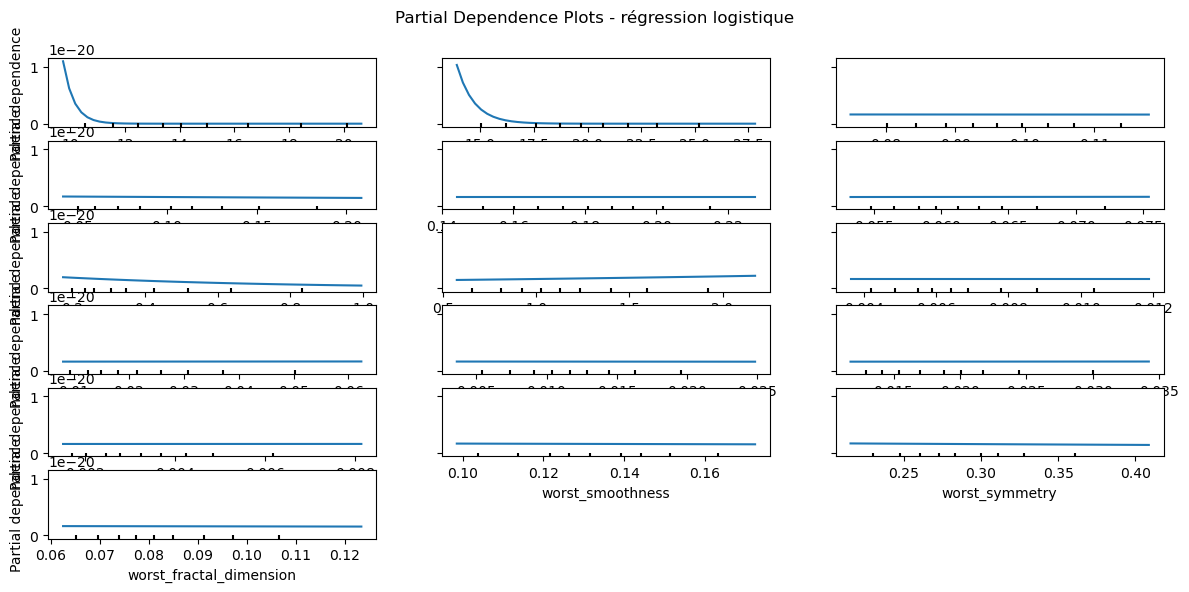

In [68]:
# Définir nos variables d'intérêts dans une liste
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)

lgr_modele = lgr.fit(X_train_sc, y_train)

features = X_train_sc.columns # Index des caractéristiques

_, ax1 = plt.subplots(figsize = (12,6))

PartialDependenceDisplay.from_estimator(lgr_modele, # votre modèle

                                         X_train, # Jeu d'entrainement

                                         features, # features

                                         kind="average", # Pour obtenir une PDP

                                         grid_resolution=50, #Nombre de points estimés pour le tracer de la courbe

                                         ax = ax1 # Paramètre de matplotlib
                                         )

plt.suptitle("Partial Dependence Plots - régression logistique")

plt.tight_layout()

plt.show()

#####  Accumulated Local Effect

In [71]:
!pip install alibi

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
s3fs 2023.3.0 requires fsspec==2023.3.0, but you have fsspec 2024.12.0 which is incompatible.



  Obtaining dependency information for alibi from https://files.pythonhosted.org/packages/bc/00/bc8caafbabf675a15f08e8cd6d86eedb5949e2cec5ec73157d71f62abd79/alibi-0.9.6-py3-none-any.whl.metadata
  Using cached alibi-0.9.6-py3-none-any.whl.metadata (22 kB)
  Obtaining dependency information for blis<0.8.0 from https://files.pythonhosted.org/packages/2f/09/da0592c74560cc33396504698122f7a56747c82a5e072ca7d2c3397898e1/blis-0.7.11-cp311-cp311-win_amd64.whl.metadata
  Using cached blis-0.7.11-cp311-cp311-win_amd64.whl.metadata (7.6 kB)
  Obtaining dependency information for transformers<5.0.0,>=4.7.0 from https://files.pythonhosted.org/packages/7b/9f/92d3091c44cb19add044064af1bf1345cd35fbb84d32a3690f912800a295/transformers-4.48.1-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/44.4 kB ? eta -:--:--
     ------------------------------------ --- 41.0/44.4 kB 2.0 MB/s eta 0:00:01
     -------------------------------------- 44.4/44.4 kB 726.6 kB/s eta 0:00:00
  Obtai

In [72]:
from alibi.explainers import ALE, plot_ale

C:\Users\Jasmine\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


C:\Users\Jasmine\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Jasmine\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Jasmine\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Jasmine\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Jasmine\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Us

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

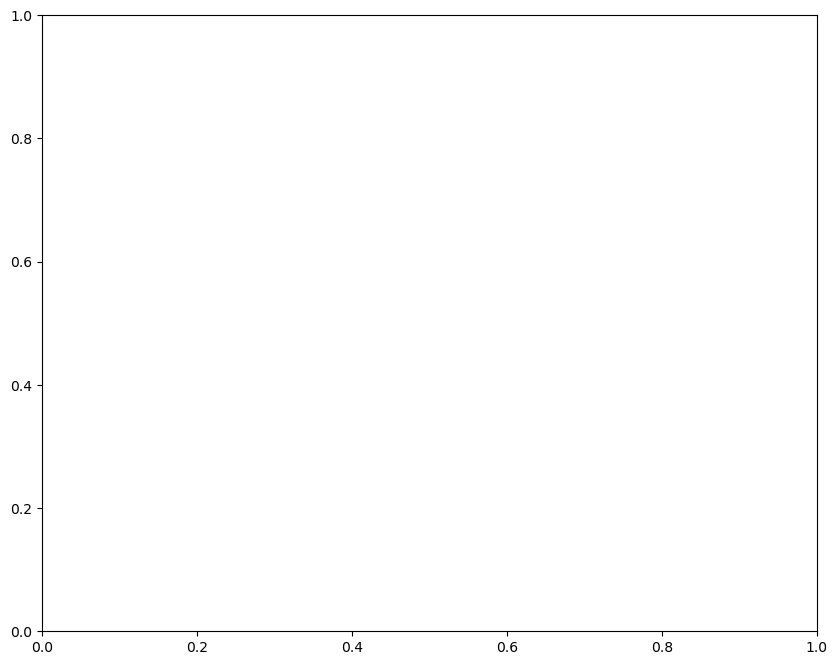

In [76]:
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)

lgr_modele = lgr.fit(X_train_sc, y_train)

features_names = X_train_sc.columns


lgr_modele_ale = ALE(lgr_modele.predict, #Methode predict de votre modèle

             feature_names=features_names, # Liste des features où il faut calculer l'ALE

             target_names=["target"] # Nom de la target

) 

#Calcul des ALE, attention il faut un format numpy arrray

lgr_exp = lgr_modele_ale.explain(X_train.to_numpy()) 


#Plot pour l'interprétation


_, ax1 = plt.subplots(figsize = (10,8))

plot_ale(lgr_exp, #Résultats des ALE

     features=X_train_sc.columns, # Feature à représenter

     ax= ax1, 

     targets=[0] # Si classification mutliple, passer le nom de toutes les modalités à prédire

)

##### H-Statistic

#### 6) Commenter et discuter des limites

#### 7) Interpréter votre modèle non linéaire (SVM avec noyau) avec l'aide des méthodes globales